# AMPLAB Module 4 Machine Listening - Sound Classification

This notebook includes the code to run a simple sound classification experiment using BSD10k dataset. We have already pre-computed embeddings of different types for all the sounds in BSD10k, so you don't need to deal with the audio. You should be able to run this notebook locally or in Google Colab without problems.

In order to run this notebook locally, you'll need to create a Python virtual environment and install the requirements (`pip install -r requirements.txt`). Also, you'll need to download the file  `amplab_machine_listening_module_data.zip` that [you'll find in this shared folder](https://drive.google.com/drive/folders/1FHEmzEXgBV1CCAWo_F3KDpw9QM5ecuZf?usp=sharing), and place it uncompressed next to this notebook (the uncompressed folder should be named `amplab_machine_listening_module_data`).

If running in Google Colab, you'll need to make a copy of this notebook somewhere in your Google Drive, and add a shortcut to the `amplab_data` shared folder next to your notebook (the shortcut must be named same as the folder, `amplab_data`). Then run the cells normally. Note that before running the first cell, you'll need to update the `%cd ...` path to set the working directory to the folder where the notebook (and the shortcut) are placed within your Google Drive. If in Colab, running the first cell will take some minutes as it needs to copy some data and unzip.

This work is similar to that of a paper we published at DCASE 2024:
[Anastasopoulou, Panagiota, et al. "Heterogeneous sound classification with the Broad Sound Taxonomy and Dataset." DCASE Workshop (2024)](https://dcase.community/documents/workshop2024/proceedings/DCASE2024Workshop_Anastasopoulou_39.pdf).

In [1]:
try:
  from google.colab import drive
  # If this does not fail, it means we're running in a Colab environment

  # First mount google drive
  drive.mount('/content/drive')

  # Set the working directory to the directory where this notebook has been placed.
  # This directory should have a Google Drive shortcut to the "amplab_data" shared folder.
  # Edit the below to point to the Google Drive directory where this notebook is located.
  %cd '/content/drive/MyDrive/SMC/AMPLab2425/AMPLAB 2025 Module 4 - Machine Listening'

  # Now copy data files to the colab runtime local storage and uncompress the .zip file.
  # By placing data files in the notebook runtime local storage, we will make data loading much faster in the cells below.
  !cp "amplab_data/amplab_machine_listening_module_data.zip" /content/amplab_machine_listening_module_data.zip
  !unzip  -u /content/amplab_machine_listening_module_data.zip -d /content/
  DATA_FOLDER = '/content/amplab_machine_listening_module_data'

except:
  # Not running in Colab
  DATA_FOLDER = 'amplab_machine_listening_module_data'

import os
import pandas as pd
import numpy as np
from IPython.display import display, IFrame
import matplotlib.pyplot as plt

import json
import sys
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data preparation

In [ ]:
# Load dataset metadata
dataset_df = pd.read_csv(open(os.path.join(DATA_FOLDER, 'BSD10k_metadata.csv')))
taoxnomy_names = json.load(open(os.path.join(DATA_FOLDER, 'taxonomy_names.json')))
display(dataset_df)
display(taoxnomy_names)

,sound_id,class,class_idx,class_top,set,uploader,license,tags,title
0,185755,fx-o,11,fx,train,marcgp13,http://creativecommons.org/licenses/by/3.0/,"campus-upf,UPF-CS13,microwave,heat,bell,noise",microwave_oven.wav
1,358405,is-w,5,is,train,MTG,http://creativecommons.org/licenses/by/3.0/,"good-sounds,single-note,multisample,sax,neuman...",Sax Alto - F5
2,358760,is-w,5,is,train,MTG,http://creativecommons.org/licenses/by/3.0/,"good-sounds,sax,neumann-U87,GsharpMajor,scale,...",Sax Alto - G# Major
3,432206,fx-o,11,fx,train,curesforbrokenhearts,http://creativecommons.org/publicdomain/zero/1.0/,"egg-shaker,shaker,percussion",EGG SHAKER
4,80630,sp-s,8,sp,train,tim.kahn,https://creativecommons.org/licenses/by/4.0/,"american,english,female,fight,speak,talk,text,...",mechanics.wav
...,...,...,...,...,...,...,...,...,...
10304,102106,fx-h,14,fx,train,sagetyrtle,http://creativecommons.org/publicdomain/zero/1.0/,"applauding,applause,binaural,cheer,cheering,cl...",072510_crowd_cheer_01.wav
10305,196075,fx-h,14,fx,train,arnaud coutancier,http://creativecommons.org/licenses/by-nc/3.0/,"children,laughter,child,laugh,field,recording,...",Children's laughter #31 rires d'enfants.wav
10306,164689,fx-ex,17,fx,train,deleted_user_2104797,http://creativecommons.org/publicdomain/zero/1.0/,"speak,cartoon,speech,phone,telephone,babble,of...",Phone_voice_cartoon.wav
10307,61752,sp-s,8,sp,train,dobroide,https://creativecommons.org/licenses/by/4.0/,"insults,male,spanish,vocal",insultos045.wav


{'m-sp': 'Solo percussion',
 'm-si': 'Solo instrument',
 'm-m': 'Multiple instruments',
 'm-other': 'Other',
 'is-p': 'Percussion',
 'is-s': 'String',
 'is-w': 'Wind',
 'is-k': 'Keyboard',
 'is-e': 'Synths / Electronic',
 'is-other': 'Other',
 'sp-s': 'Solo speech',
 'sp-c': 'Conversation / Crowd',
 'sp-p': 'Processed / Synthetic',
 'sp-other': 'Other',
 'fx-o': 'Objects / House appliances',
 'fx-v': 'Vehicles',
 'fx-m': 'Other mechanisms, engines, machines',
 'fx-h': 'Human sounds and actions',
 'fx-a': 'Animals',
 'fx-n': 'Natural elements and explosions',
 'fx-d': 'Design',
 'fx-ex': 'Experimental',
 'fx-el': 'Electronic & Design',
 'fx-other': 'Other',
 'ss-n': 'Nature',
 'ss-i': 'Indoors',
 'ss-u': 'Urban',
 'ss-s': 'Synthetic / Artificial',
 'ss-other': 'Other',
 'm': 'Music',
 'is': 'Instrument samples',
 'ss': 'Soundscapes',
 'fx': 'Sound effects',
 'sp': 'Speech'}

#### The Broad Sound Taxonomy

![Broad Sound Taxonomy](https://raw.githubusercontent.com/allholy/BSD10k/refs/heads/main/BST_diagram.png)

In [ ]:
# Utils function to be able to listen to actual sounds
# WARNING: it could be that some sounds in BSD10k are not available anymore in Freesound (e.g., removed by the user)

def show_sound_player(sound_id):
  display(IFrame(f'https://freesound.org/embed/sound/iframe/{sound_id}/simple/medium/', width=596, height=100))


# Let's listen to some sounds of each class
for class_key in taoxnomy_names.keys():
  class_df = dataset_df[dataset_df['class']==class_key]
  if len(class_df) > 0:
    print(taoxnomy_names[class_key])
    show_sound_player(class_df.iloc[0]['sound_id'])
    show_sound_player(class_df.iloc[1]['sound_id'])
    show_sound_player(class_df.iloc[2]['sound_id'])


Solo percussion


Solo instrument


Multiple instruments


Percussion


String


Wind


Keyboard


Synths / Electronic


Solo speech


Conversation / Crowd


Processed / Synthetic


Objects / House appliances


Vehicles


Other mechanisms, engines, machines


Human sounds and actions


Animals


Natural elements and explosions


Experimental


Electronic & Design


Nature


Indoors


Urban


Synthetic / Artificial


## Load data and train model

In [8]:
# Load dataset embeddings
# NOTE: here you can choose between different types of embeddings

def load_embeddings_for_dataset(df, embeddings_folder):
  # Returns a numpy array of shape (n, d) where "n" is the number of sounds in the dataset and "d" is the number of dimensions of the embeddings
  # Available embedding types: "clap", "fs_similarity", "fsdsinet", "mfcc", "fsdsinet_frames", "mfcc_frames"
  # NOTE: if you are loading embeddings which have been stored frame by frame (i.e. those ending with "_frames"), you'll need to add some code
  # here to summarize them into a one-dimensional vectors before adding them to the returned numpy array.

  base_dir = os.path.join(DATA_FOLDER, 'embeddings', embeddings_folder)
  filenames = [os.path.join(base_dir, f'{df.iloc[i]["sound_id"]}.npy') for i in range(len(df))]
  example_embedding_vector = np.load(filenames[0])
  num_dimensions = len(example_embedding_vector)

  print(f'Will load {len(filenames)} points of data with {num_dimensions} dimensions each')
  X = np.zeros((len(filenames), num_dimensions))
  for i, fn in enumerate(filenames):
    if (i + 1) % 100 == 0:
      sys.stdout.write(f'\r{i + 1}/{len(filenames)}')
      sys.stdout.flush()
    X[i, :] = np.load(fn)
  sys.stdout.write(f'\rLoaded {len(filenames)} embeddings from "{embeddings_folder}"!')
  print()

  return X

In [9]:
# Load ground truth labels
def get_ground_truth_vector(df):
  return np.array([taoxnomy_names[df.iloc[i]["class"]] for i in range(len(df))])

y = get_ground_truth_vector(dataset_df)

In [17]:
# Available embedding types: "clap", "fs_similarity", "fsdsinet", "mfcc", "fsdsinet_frames", "mfcc_frames"

# Define a function to run the complete classification pipeline for a given embedding type
def run_classification_pipeline(embeddings_folder):
  print(f"\n### Classification with {embeddings_folder} embeddings ###")
  
  # Load the embeddings
  X = load_embeddings_for_dataset(dataset_df, embeddings_folder=embeddings_folder)
  
  # Load ground truth labels
  y = get_ground_truth_vector(dataset_df)
  
  # Create train and test sets
  train_df_indices = dataset_df.index[dataset_df['set'] == 'train']
  test_df_indices = dataset_df.index[dataset_df['set'] == 'test']
  X_train = X[train_df_indices]
  y_train = y[train_df_indices]
  X_test = X[test_df_indices]
  y_test = y[test_df_indices]
  
  # Standardize features
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  
  # Create and train the model
  clf = KNeighborsClassifier()
  clf.fit(X_train, y_train)
  
  # Make predictions
  y_pred = clf.predict(X_test)
  
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Overall accuracy: {accuracy:.4f}")
  print(f"Random baseline: {1.0/len(set(y)):.4f}")
  
  return accuracy, y_test, y_pred


### Classification with clap embeddings ###
Will load 10309 points of data with 512 dimensions each
Loaded 10309 embeddings from "clap"!
Overall accuracy: 0.7348
Random baseline: 0.0435

### Classification with fs_similarity embeddings ###
Will load 10309 points of data with 100 dimensions each
Loaded 10309 embeddings from "fs_similarity"!
Overall accuracy: 0.4109
Random baseline: 0.0435

### Classification with fsdsinet embeddings ###
Will load 10309 points of data with 512 dimensions each
Loaded 10309 embeddings from "fsdsinet"!
Overall accuracy: 0.5413
Random baseline: 0.0435

### Classification with mfcc embeddings ###
Will load 10309 points of data with 13 dimensions each
Loaded 10309 embeddings from "mfcc"!
Overall accuracy: 0.2707
Random baseline: 0.0435

### Comparison of embedding types ###
clap: 0.7348
fsdsinet: 0.5413
fs_similarity: 0.4109
mfcc: 0.2707


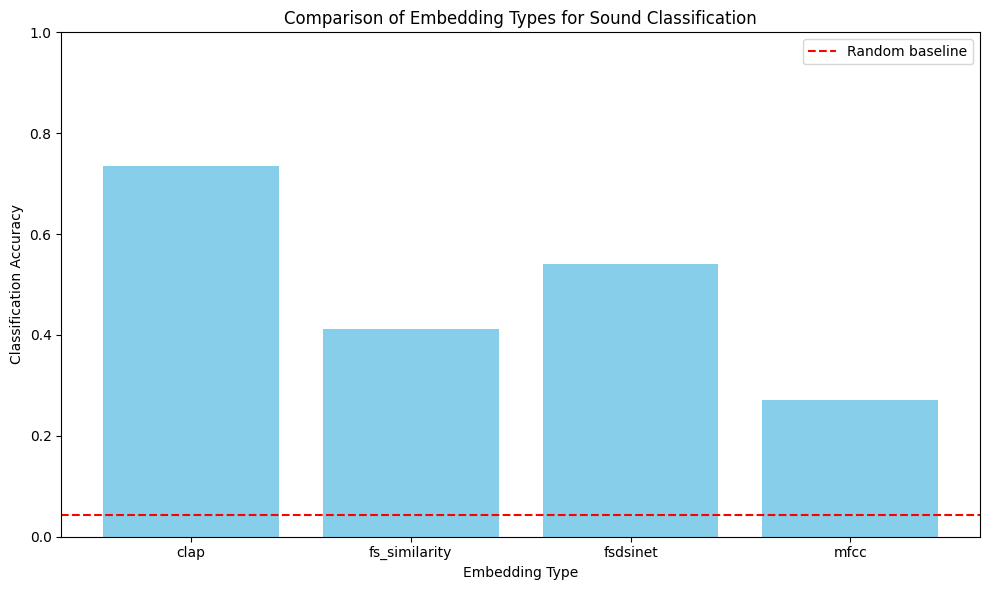

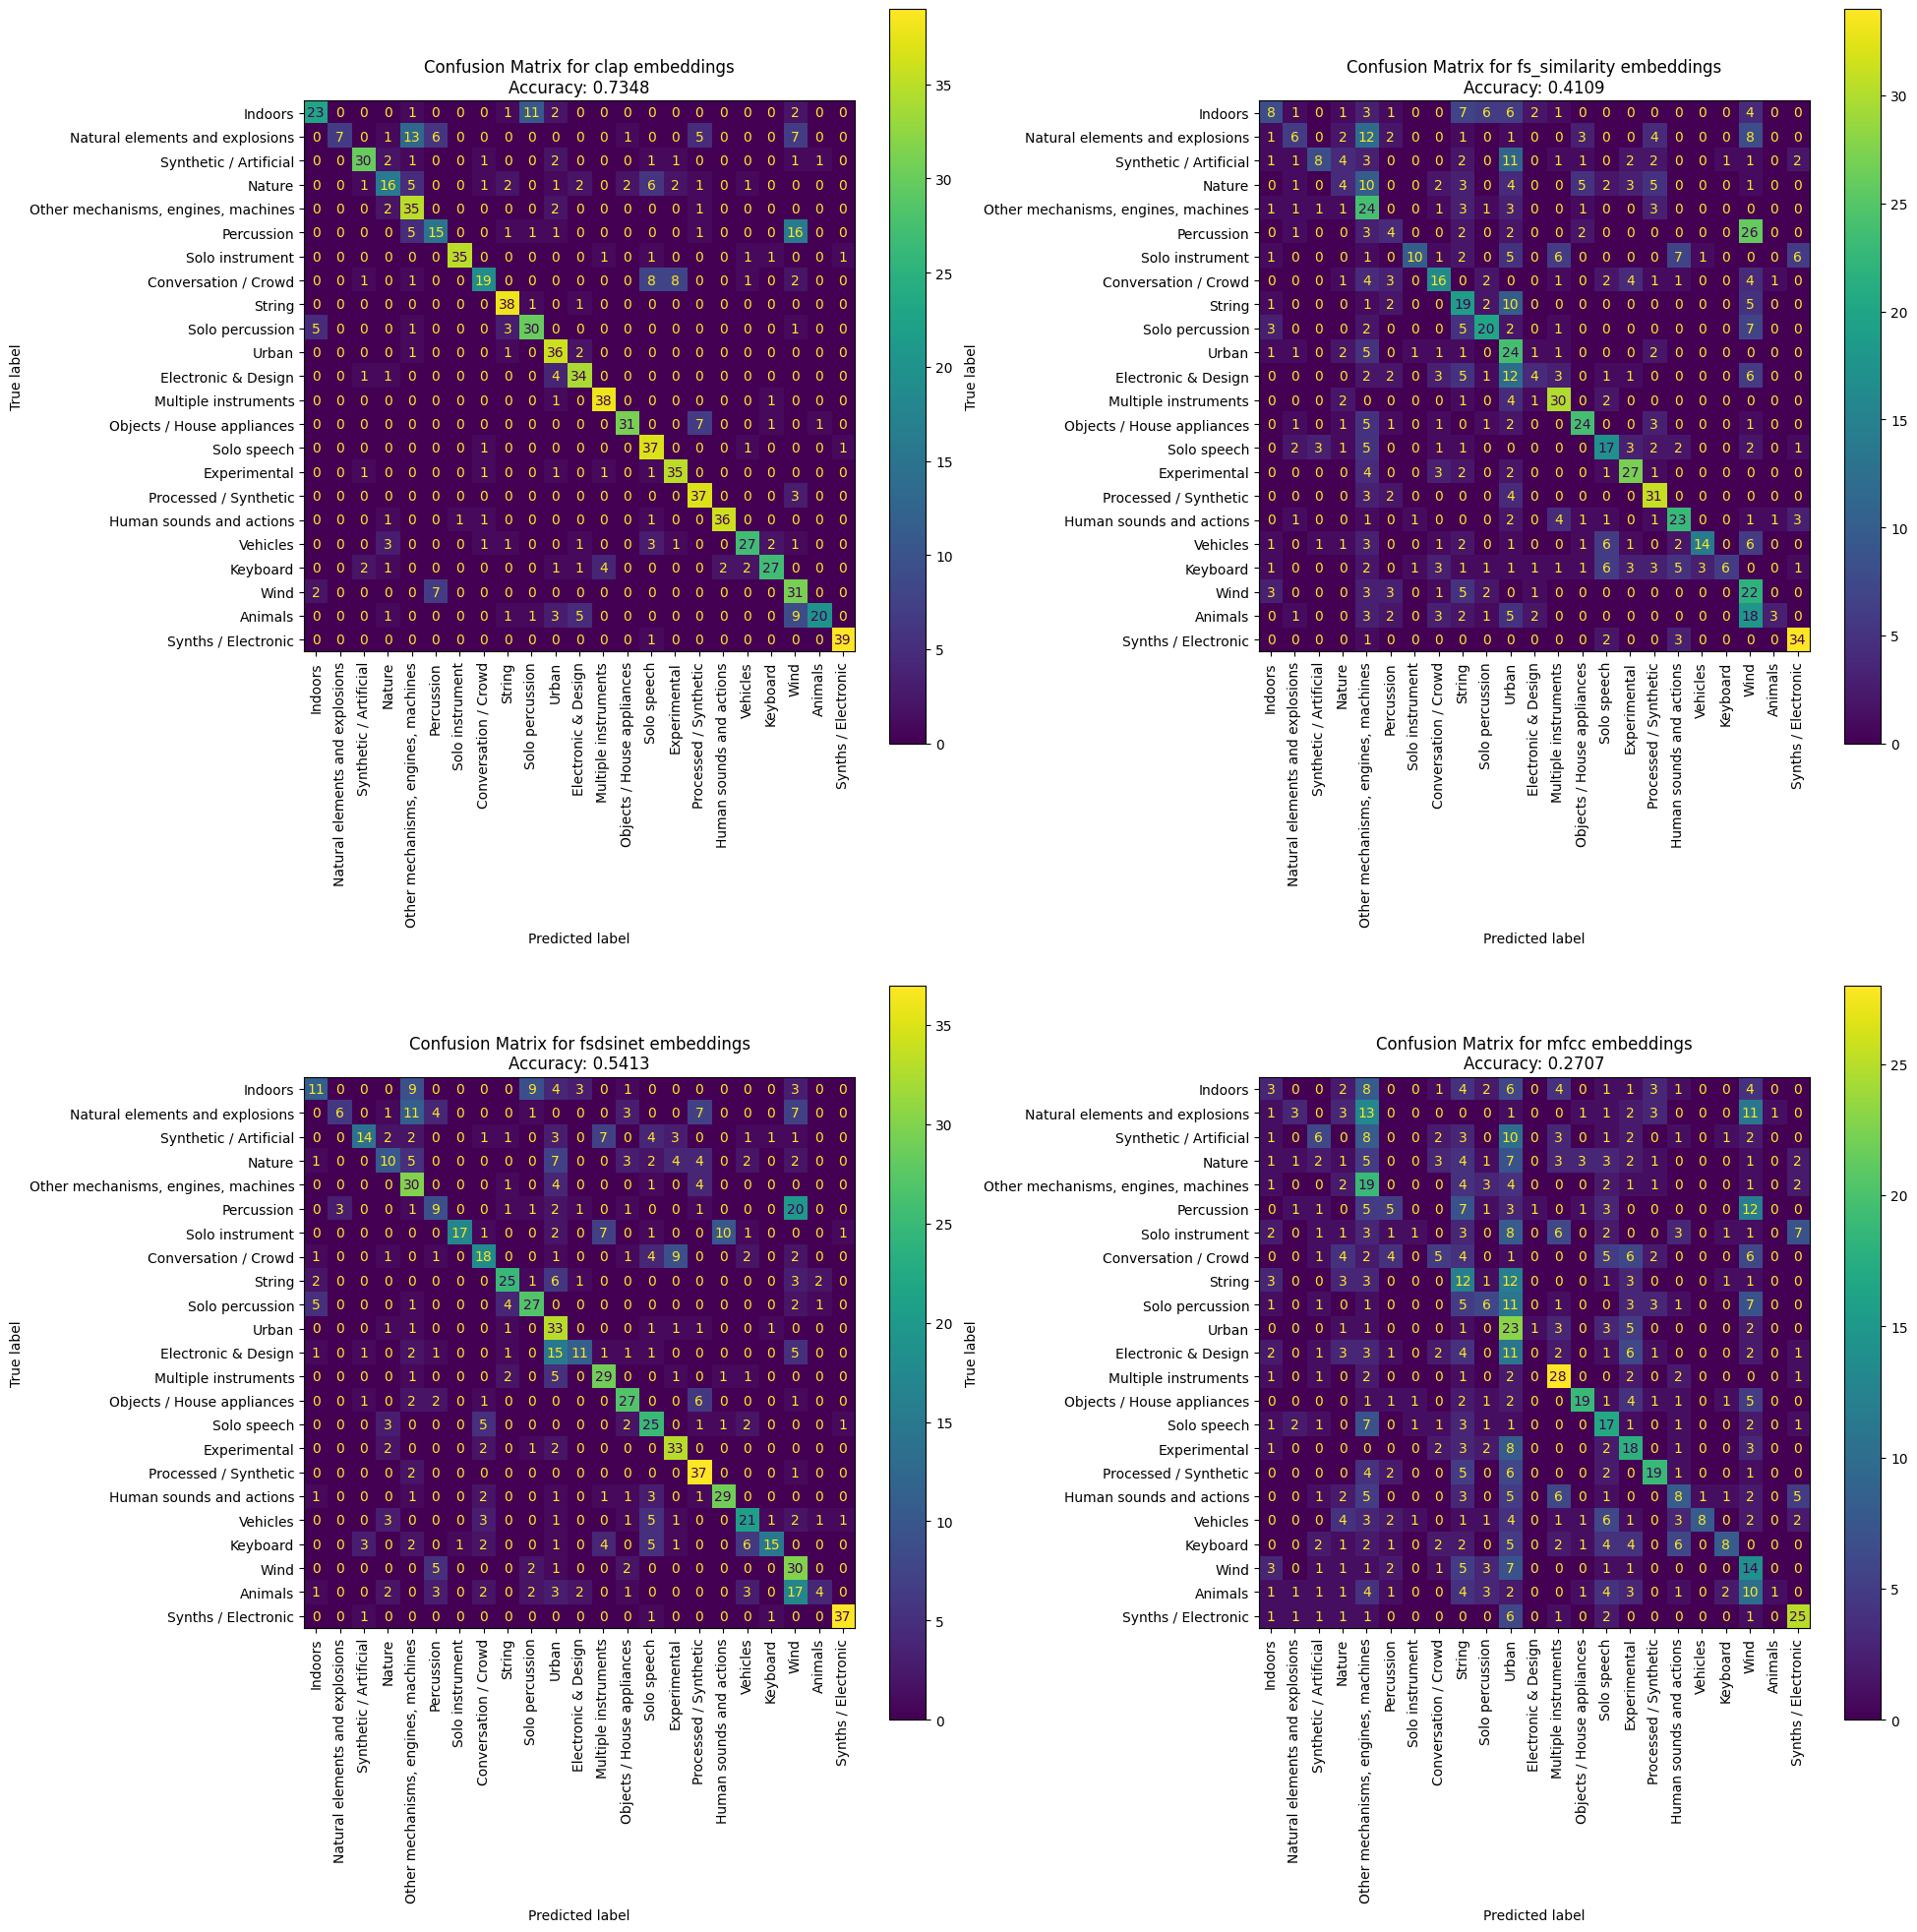

In [44]:
# List of embedding types to test
embedding_types = ["clap", "fs_similarity", "fsdsinet", "mfcc"]

# Run the pipeline for each embedding type and store results
results = {}
for embedding_type in embedding_types:
  try:
    accuracy, y_test, y_pred = run_classification_pipeline(embedding_type)
    results[embedding_type] = {
      "accuracy": accuracy,
      "y_test": y_test,
      "y_pred": y_pred
    }
  except Exception as e:
    print(f"Error with {embedding_type}: {e}")

# Compare results
print("\n### Comparison of embedding types ###")
for embedding_type, result in sorted(results.items(), key=lambda x: x[1]["accuracy"], reverse=True):
  print(f"{embedding_type}: {result['accuracy']:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
accuracies = [results[et]["accuracy"] for et in results.keys()]
plt.bar(list(results.keys()), accuracies, color='skyblue')
plt.axhline(y=1.0/len(set(y)), color='r', linestyle='--', label='Random baseline')
plt.xlabel('Embedding Type')
plt.ylabel('Classification Accuracy')
plt.title('Comparison of Embedding Types for Sound Classification')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Create a 2x2 grid to show confusion matrices for all embedding types
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()

# Plot confusion matrix for each embedding type
for i, embedding_type in enumerate(embedding_types):
    y_test = results[embedding_type]["y_test"]
    y_pred = results[embedding_type]["y_pred"]
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=list(set(y_test)))
    cm_display.plot(ax=axs[i], xticks_rotation=90)
    axs[i].set_title(f'Confusion Matrix for {embedding_type} embeddings\nAccuracy: {results[embedding_type]["accuracy"]:.4f}')

plt.tight_layout()
plt.show()


Showing confusion matrix for best performing embedding: clap


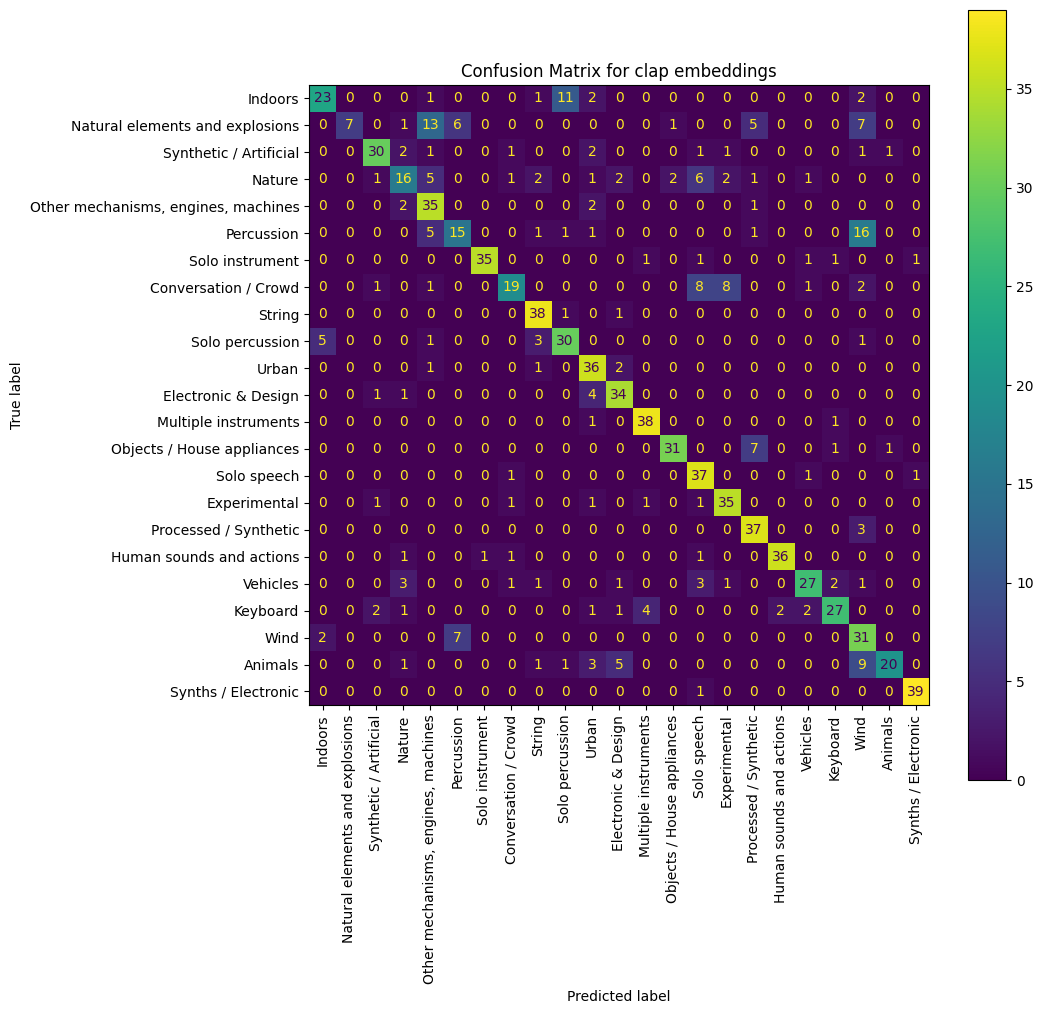

In [45]:

# Show confusion matrix for the best performing embedding type
best_embedding = max(results.items(), key=lambda x: x[1]["accuracy"])[0]
print(f"\nShowing confusion matrix for best performing embedding: {best_embedding}")

best_y_test = results[best_embedding]["y_test"]
best_y_pred = results[best_embedding]["y_pred"]

# Generate the confusion matrix
cm = confusion_matrix(best_y_test, best_y_pred)
fig, ax = plt.subplots(figsize=(10,10))
cm_display = ConfusionMatrixDisplay(cm, display_labels=list(set(best_y_test)))
cm_display.plot(ax=ax)
plt.xticks(rotation=90)
plt.title(f'Confusion Matrix for {best_embedding} embeddings')

plt.show()


## Audition misclassified sounds

It is quite clear that CLAP performs the best amongst the embedding types. FSDINet does quite well, compared to the rest but there is still a significant gap between that and CLAP. So we will investigate CLAP for our Misclassification Analysis & Comparisons.

In [46]:
X = load_embeddings_for_dataset(dataset_df, embeddings_folder="clap")

# Create train and test sets (note that BSD10K already defiens such sets, so we can use them directly)
train_df_indices = dataset_df.index[dataset_df['set'] == 'train']
test_df_indices = dataset_df.index[dataset_df['set'] == 'test']
X_train = X[train_df_indices]
y_train = y[train_df_indices]
X_test = X[test_df_indices]
y_test = y[test_df_indices]

Will load 10309 points of data with 512 dimensions each
Loaded 10309 embeddings from "clap"!


In [49]:
# Randomply select 5 misclassifications and listen to them
misclassified_sounds = []
for misclassified_test_index in np.where(y_test != y_pred)[0]:
    dataset_df_index = test_df_indices[misclassified_test_index]
    misclassified_sounds.append([
        dataset_df.iloc[dataset_df_index]['sound_id'],
        y_test[misclassified_test_index],
        y_pred[misclassified_test_index]
    ])

for sound_id, ground_truth, predicted in random.sample(misclassified_sounds, 5):
    print('---------------------------------------')
    print(dataset_df[dataset_df['sound_id'] == sound_id]['title'].values[0])
    print("Ground truth: ", ground_truth)
    print("Predicted:", predicted)
    show_sound_player(sound_id)


---------------------------------------
electribe-kicks slice 01 [C#4].wav
Ground truth:  Synths / Electronic
Predicted: Objects / House appliances


---------------------------------------
recording the sound of hailstones.mp3
Ground truth:  Urban
Predicted: Nature


---------------------------------------
Ticking clock
Ground truth:  Other mechanisms, engines, machines
Predicted: Objects / House appliances


---------------------------------------
Woman Yandere Laugh
Ground truth:  Human sounds and actions
Predicted: Natural elements and explosions


---------------------------------------
Sword Fight Hat.aif
Ground truth:  Percussion
Predicted: Solo percussion


After listening to some random samples and comparing their Ground Truth and Predicted Class, we can conclude that there are two different types of misclassifications.
    
- Due to ambiguity in sounds that sound similar which are understandably misclassified due to similar acoustic properties

- Incorrectly labelled ground truth (some might argue the predicted label is correct)
    
    > Example - recording the sound of hailstones.mp3, Ground truth:  Urban, Predicted: Nature
                    
- **Ambiguity in the taxonomies, where one could argue that the ground truth was potentially mislabelled or that both predicted and ground truth labels are accurate.**

    > In particular, classes like - 'Conversation / Crowd', 'Solo speech', 'Human sounds and actions'; 'Indoors', 'Urban', 'Vehicles', often have sounds that could belong in either class. It would be incorrect to say they are *misclassified*.

    Some examples of this were identified by listening to different random samples, which are shown below.

### **Ambiguous Class Names (Sounds could belong in either class)**

In [38]:
# Define the file names we want to listen to
file_names = ['20111030.pandemonium.wav', 'Free Music.wav', '0182 Inmigration_office.wav', 'getgetityougotitwhooclaps.mp3', 
              '20101230_passing.motorcycle.wav', 'Car revs and drives away 2.WAV', 'trains_meet_on_bridge.wav']

# Find and display each sound by matching titles in the dataset
for file_name in file_names:
    # Find records that contain this filename in their title
    matching_sounds = dataset_df[dataset_df['title'].str.contains(file_name, case=False, regex=False, na=False)]
    
    if not matching_sounds.empty:
        sound_id = matching_sounds.iloc[0]['sound_id']
        # Try to find this sound in misclassified sounds to get ground truth and predicted labels
        misclassified_info = next((item for item in misclassified_sounds if item[0] == sound_id), None)
        
        print('---------------------------------------')
        print(f"File: {file_name}")
        print(f"Title: {matching_sounds.iloc[0]['title']}")
        
        if misclassified_info:
            ground_truth, predicted = misclassified_info[1], misclassified_info[2]
            print("Ground truth:", ground_truth)
            print("Predicted:", predicted)
        else:
            # If not in misclassified sounds, just show the class from dataset
            print("Class:", matching_sounds.iloc[0]['class'])
            
        show_sound_player(sound_id)
    else:
        print(f'---------------------------------------')
        print(f"Sound file '{file_name}' not found in the dataset")

---------------------------------------
File: 20111030.pandemonium.wav
Title: 20111030.pandemonium.wav
Ground truth: Indoors
Predicted: Conversation / Crowd


---------------------------------------
File: Free Music.wav
Title: Free Music.wav
Ground truth: Conversation / Crowd
Predicted: Solo speech


---------------------------------------
File: 0182 Inmigration_office.wav
Title: 0182 Inmigration_office.wav
Ground truth: Conversation / Crowd
Predicted: Objects / House appliances


---------------------------------------
File: getgetityougotitwhooclaps.mp3
Title: getgetityougotitwhooclaps.mp3
Ground truth: Conversation / Crowd
Predicted: Human sounds and actions


---------------------------------------
File: 20101230_passing.motorcycle.wav
Title: 20101230_passing.motorcycle.wav
Ground truth: Vehicles
Predicted: Urban


---------------------------------------
File: Car revs and drives away 2.WAV
Title: Car revs and drives away 2.WAV
Ground truth: Vehicles
Predicted: Urban


---------------------------------------
File: trains_meet_on_bridge.wav
Title: trains_meet_on_bridge.wav
Ground truth: Vehicles
Predicted: Urban
